In [1]:
#General import
import numpy as np
import scipy.sparse as sparse
import time
import matplotlib.pyplot as plt

In [2]:
# pyMPC and kalman import
from pyMPC.mpc import MPCController
from kalman import kalman_filter_simple

## System dynamics ##

The system to be controlled is an inverted pendulum on a cart (see next Figure).  

<img src="img/cart_pole.png" width="250" align="center"/>

The system is governed by the following differential equations:

\begin{equation}
 \begin{aligned}
 (M+m)\ddot p + ml\ddot\phi \cos\phi - ml \dot \phi ^2 \sin \phi + b\dot p &= F \\
 l \ddot \phi + \ddot p \cos \phi - g \sin\phi &= -f_\phi\dot \phi
\end{aligned}
\end{equation}

Introducing the state vector $x=[p\; \dot p\; \phi\; \dot \phi]$ and the input $u=F$, the system dynamics are described in state-space by a set of an nonlinear ordinary differential equations: $\dot x = f(x,u)$ with

\begin{equation}
\begin{split}
  f(x,u) &= 
 \begin{bmatrix}
 x_2\\
 \frac{-mg \sin x_3\cos x_3 + mlx_4^3\sin x_3 + f_\phi m x_4 \cos x_3 - bx_2 + u }{M+(1-\cos^2 x_3)m}\\
 x_3\\
 \frac{(M+m)(g \sin x_3 - f_\phi x_4) - (lm x_4^2 \sin x_3 - bx_2 + u)\cos x_3}{l(M+(1-\cos^2 x_3)m)}
 \end{bmatrix}\\ 
 \end{split}
 \end{equation}

For MPC control design, the system is linearized about the upright (unstable) equilibrium point, i.e., about the point $x_{eq} = [0, \; 0\;, 0,\; 0]^\top$.
The linearized system has form $\dot  x =  A_c x + B_c u$ with

\begin{equation}
  A = 
 \begin{bmatrix}
 0& 1& 0& 0\\
 0& -\frac{b}{M}& -g\frac{m}{M}& f_\theta\frac{m}{M}\\
 0&0&0&1\\
 0&\frac{b}{Ml}& \frac{g(M+m)}{Ml}&-\frac{(M+m)f_\theta}{M l}
 \end{bmatrix},\qquad B= 
 \begin{bmatrix}
 0\\
 \frac{1}{M}\\
 0\\
 -\frac{1}{Ml}&
 \end{bmatrix}
 \end{equation}
 
Next, the system is discretized with sampling time $T_s = 0.50\;\text{ms}$. Here we just use Forward Euler integration for the sake of simplicity.


In [3]:
# Constants #

M = 0.5
m = 0.2
b = 0.1
ftheta = 0.1
l = 0.3
g = 9.81

Ts = 25e-3

In [4]:
# Linearized System Matrices 

Ac =np.array([[0, 1, 0, 0],
               [0, -b / M, -(g * m) / M, (ftheta * m) / M],
               [0, 0, 0, 1],
               [0, b / (M * l), (M * g + g * m) / (M * l), -(M * ftheta + ftheta * m) / (M * l)]])

Bc = np.array([
    [0.0],
    [1.0 / M],
    [0.0],
    [-1 / (M * l)]
])

Cc = np.array([[1., 0., 0., 0.],
               [0., 0., 1., 0.]])

Dc = np.zeros((2, 1))

[nx, nu] = Bc.shape  # number of states and number or inputs
ny = np.shape(Cc)[0]

In [5]:
# Brutal forward euler discretization

Ad = np.eye(nx) + Ac * Ts
Bd = Bc * Ts
Cd = Cc
Dd = Dc

In [6]:
# Standard deviation of the measurement noise on position and angle

std_npos = 0.01
std_nphi = 0.01

In [7]:
# Reference input and states
xref = np.array([0.3, 0.0, 0.0, 0.0])  # reference state
uref = np.array([0.0])  # reference input
uminus1 = np.array([0.0])  # input at time step negative one - used to penalize the first delta u at time instant 0. Could be the same as uref.

In [8]:
# Constraints
xmin = np.array([-10.0, -10.0, -100, -100])
xmax = np.array([10.0, 10.0, 100, 100])

umin = np.array([-20])
umax = np.array([20])

Dumin = np.array([-5])
Dumax = np.array([5])

In [9]:
# Objective function weights
Qx = sparse.diags([1.0, 0, 1.0, 0])  # Quadratic cost for states x0, x1, ..., x_N-1
QxN = sparse.diags([1.0, 0, 1.0, 0])  # Quadratic cost for xN
Qu = 0.0 * sparse.eye(1)  # Quadratic cost for u0, u1, ...., u_N-1
QDu = 0.1 * sparse.eye(1)  # Quadratic cost for Du0, Du1, ...., Du_N-1

In [10]:
# Initial state
phi0 = 15 * 2 * np.pi / 360
x0 = np.array([0, 0, phi0, 0])  # initial state

# Prediction horizon
Np = 40

In [11]:
# Instantiate and initialize MPC controller
K = MPCController(Ad, Bd, Np=Np, x0=x0, xref=xref, uminus1=uminus1,
                  Qx=Qx, QxN=QxN, Qu=Qu, QDu=QDu,
                  xmin=xmin, xmax=xmax, umin=umin, umax=umax, Dumin=Dumin, Dumax=Dumax)
K.setup()

C:\Users\marco\Anaconda3\envs\RL\lib\site-packages\osqp\interface.py:109: UserWarning: Converting sparse P to a CSC (compressed sparse column) matrix. (It may take a while...)
  "(compressed sparse column) matrix. (It may take a while...)")


In [12]:
# Basic Kalman filter design
Q_kal = 10 * np.eye(nx)
R_kal = np.eye(ny)
L,P,W  = kalman_filter_simple(Ad, Bd, Cd, Dd, Q_kal, R_kal)

In [13]:
# Simulate in closed loop
[nx, nu] = Bd.shape  # number of states and number or inputs
len_sim = 100  # simulation length (s)
nsim = int(len_sim / Ts)  # simulation length(timesteps)
x_vec = np.zeros((nsim, nx))
y_vec = np.zeros((nsim, ny))
x_est_vec = np.zeros((nsim, nx))
u_vec = np.zeros((nsim, nu))
t_vec = np.arange(0, nsim) * Ts

time_start = time.time()

x_step = x0
x_step_est = x0

uMPC = uminus1
for i in range(nsim):
    # Output for step i
    # System
    y_step = Cd.dot(x_step)  # y[k+1]
    ymeas_step = y_step
    ymeas_step[0] += std_npos*np.random.randn()
    ymeas_step[1] += std_nphi*np.random.randn()
    # Estimator
    yest_step = Cd.dot(x_step_est)
    # MPC
    uMPC = K.output()  # MPC step (u_k value)

    # Save output for step i
    y_vec[i, :] = y_step
    u_vec[i, :] = uMPC
    x_vec[i, :] = x_step
    x_est_vec[i, :] = x_step_est

    # Update i+1
    # System
    F = uMPC
    v = x_step[1]
    theta = x_step[2]
    omega = x_step[3]
    der = np.zeros(nx)
    der[0] = v
    der[1] = (m * l * np.sin(theta) * omega ** 2 - m * g * np.sin(theta) * np.cos(theta) + m * ftheta * np.cos(
        theta) * omega + F - b * v) / (M + m * (1 - np.cos(theta) ** 2))
    der[2] = omega
    der[3] = ((M + m) * (g * np.sin(theta) - ftheta * omega) - m * l * omega ** 2 * np.sin(theta) * np.cos(theta) - (
                F - b * v) * np.cos(theta)) / (l * (M + m * (1 - np.cos(theta) ** 2)))
    x_step = x_step + der * Ts  # x[k+1] #x_step = Ad.dot(x_step) + Bd.dot(uMPC)

    # Estimator
    x_step_est = Ad.dot(x_step_est) + Bd.dot(uMPC)  # x[k+1|k]
    x_step_est = x_step_est + L @ (ymeas_step - yest_step)  # x[k+1|k+1]

    # MPC update
    K.update(x_step_est, uMPC)  # update with measurement #

time_sim = time.time() - time_start

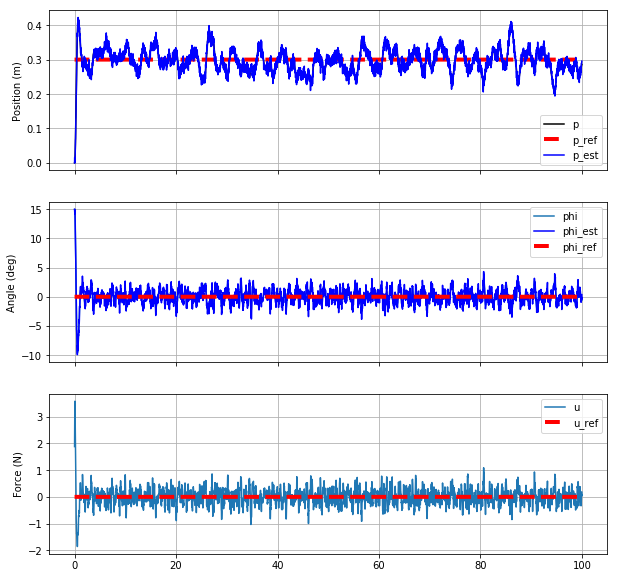

In [14]:
# Plot results

fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
axes[0].plot(t_vec, x_vec[:, 0], "k", label='p')
axes[0].plot(t_vec, xref[0] * np.ones(np.shape(t_vec)), "r--", linewidth=4, label="p_ref")
axes[0].plot(t_vec, x_est_vec[:, 0], "b", label="p_est")
axes[0].set_ylabel("Position (m)")

axes[1].plot(t_vec, x_vec[:, 2] * 360 / 2 / np.pi, label="phi")
axes[1].plot(t_vec, x_est_vec[:, 2] * 360 / 2 / np.pi, "b", label="phi_est")
axes[1].plot(t_vec, xref[1] * np.ones(np.shape(t_vec)), "r--", linewidth=4, label="phi_ref")
axes[1].set_ylabel("Angle (deg)")

axes[2].plot(t_vec, u_vec[:, 0], label="u")
axes[2].plot(t_vec, uref * np.ones(np.shape(t_vec)), "r--", linewidth=4, label="u_ref")
axes[2].set_ylabel("Force (N)")

for ax in axes:
    ax.grid(True)
    ax.legend()
